In [13]:
import itertools
import json
import os
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn import metrics

from database import data_utils, shape_utils

import importlib
importlib.reload(data_utils)

RUN_FOLDER = "../results/throwaway/"

In [14]:
# kcm_deeptte_results = data_utils.extract_deeptte_results("Seattle", RUN_FOLDER, "kcm/")
# atb_deeptte_results = data_utils.extract_deeptte_results("Trondheim", RUN_FOLDER, "atb/")
# kcm_deeptte_result_df = kcm_deeptte_results[kcm_deeptte_results['Loss Set']=="test"][['Model','City','Fold','MAPE','RMSE','MAE']].copy()
# atb_deeptte_result_df = atb_deeptte_results[atb_deeptte_results['Loss Set']=="test"][['Model','City','Fold','MAPE','RMSE','MAE']].copy()

In [15]:
kcm_model_results = data_utils.load_pkl(RUN_FOLDER + "kcm/" + "model_results.pkl")
atb_model_results = data_utils.load_pkl(RUN_FOLDER + "atb/" + "model_results.pkl")
kcm_result_df, kcm_loss_df = data_utils.extract_results("Seattle", kcm_model_results)
atb_result_df, atb_loss_df = data_utils.extract_results("Trondheim", atb_model_results)

In [16]:
# performances_df = pd.concat([kcm_result_df, atb_result_df, kcm_deeptte_result_df, atb_deeptte_result_df], axis=0).sort_values(['City','Model','MAPE'])
performances_df = pd.concat([kcm_result_df, atb_result_df], axis=0).sort_values(['City','Model','MAPE'])
model_curves_df = pd.concat([kcm_loss_df, atb_loss_df], axis=0)

In [17]:
# fig, axes = plt.subplots(1,1)
# fig.set_figheight(4)
# fig.set_figwidth(5)
# sns.lineplot(kcm_deeptte_results, x="Epoch", y="MAPE", ax=axes)
# fig.suptitle('KCM DeepTTE Training Loss (only validation curve)', fontsize=16)
# fig.tight_layout()
# plt.savefig("../plots/model_curves_deeptte_kcm.png", dpi=1800, bbox_inches='tight')

In [18]:
# plot_data = atb_deeptte_results[atb_deeptte_results['Loss Set']!="test"]
# fig, axes = plt.subplots(1,1)
# fig.set_figheight(4)
# fig.set_figwidth(5)
# sns.lineplot(plot_data, x="Epoch", y="MAPE", ax=axes)
# fig.suptitle('AtB DeepTTE Training Loss (only validation curve)', fontsize=16)
# fig.tight_layout()
# plt.savefig("../plots/model_curves_deeptte_atb.png", dpi=1800, bbox_inches='tight')

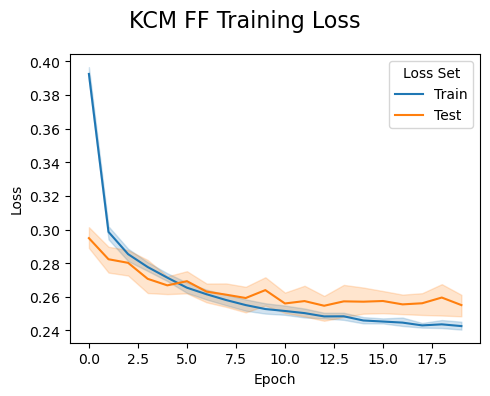

In [19]:
plot_data = model_curves_df[model_curves_df['City']=="Seattle"]
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(plot_data, x="Epoch", y="Loss", hue="Loss Set", ax=axes)
fig.suptitle('KCM FF Training Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_kcm.png", dpi=1800, bbox_inches='tight')

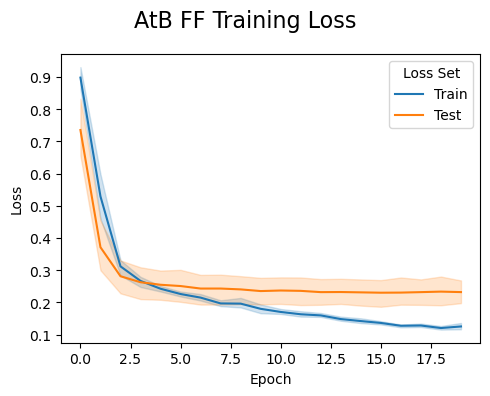

In [20]:
plot_data = model_curves_df[model_curves_df['City']=="Trondheim"]
fig, axes = plt.subplots(1,1)
fig.set_figheight(4)
fig.set_figwidth(5)
sns.lineplot(plot_data, x="Epoch", y="Loss", hue="Loss Set", ax=axes)
fig.suptitle('AtB FF Training Loss', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_curves_atb.png", dpi=1800, bbox_inches='tight')

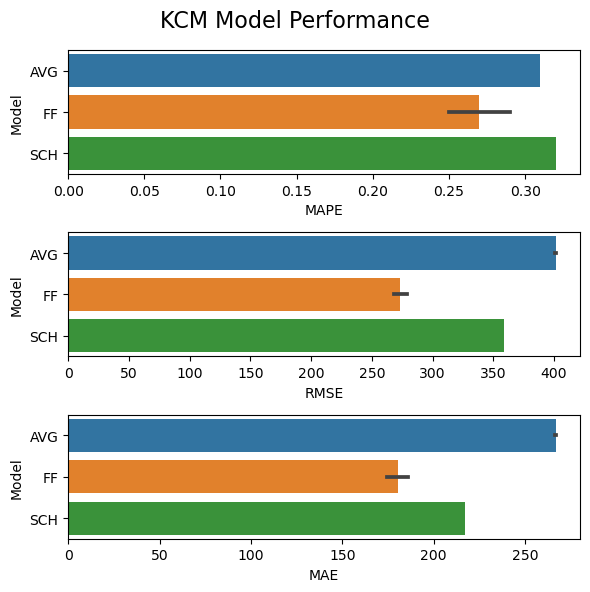

In [21]:
plot_data = performances_df[performances_df['City']=="Seattle"]
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes[0])
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[1])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[2])
fig.suptitle('KCM Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_kcm.png", dpi=1800, bbox_inches='tight')

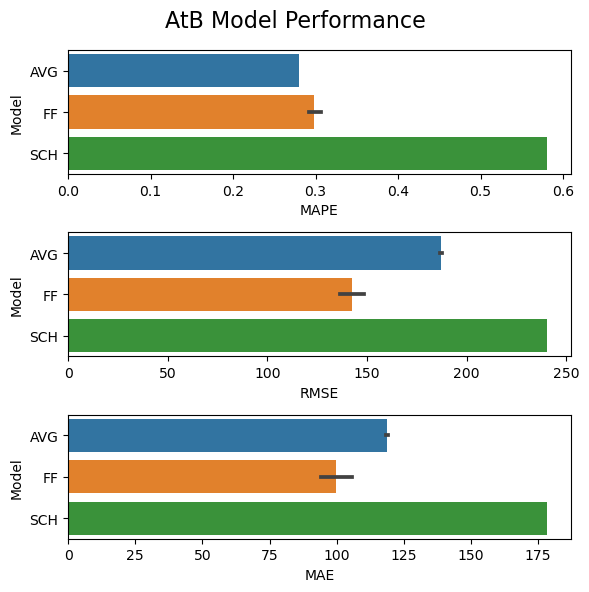

In [22]:
plot_data = performances_df[performances_df['City']=="Trondheim"]
fig, axes = plt.subplots(3,1)
fig.set_figheight(6)
fig.set_figwidth(6)
sns.barplot(plot_data, x="MAPE", y="Model", ax=axes[0])
sns.barplot(plot_data, x="RMSE", y="Model", ax=axes[1])
sns.barplot(plot_data, x="MAE", y="Model", ax=axes[2])
fig.suptitle('AtB Model Performance', fontsize=16)
fig.tight_layout()
plt.savefig("../plots/model_performances_atb.png", dpi=1800, bbox_inches='tight')